<a href="https://colab.research.google.com/github/DamnScallion/Visionary-Unicorns-Project/blob/main/yolo/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please run this file locally, not Google Colab

In [53]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [54]:
# ROOT_DIR = '/content/Visionary-Unicorns-Project/yolo'
ROOT_DIR = '../yolo/runs/detect'

VAL_DIR = '../data/original'

### Import model we trained

In [55]:
model_yolov8n_orig = YOLO(f'{ROOT_DIR}/yolov8n_orig/weights/best.pt')
model_yolov8n_5k_aug = YOLO(f'{ROOT_DIR}/yolov8n_5k_aug/weights/best.pt')

model_yolov8s_orig = YOLO(f'{ROOT_DIR}/yolov8s_orig/weights/best.pt')
model_yolov8s_5k_aug = YOLO(f'{ROOT_DIR}/yolov8s_5k_aug/weights/best.pt')

model_yolov8m_orig = YOLO(f'{ROOT_DIR}/yolov8m_orig/weights/best.pt')
model_yolov8m_5k_aug = YOLO(f'{ROOT_DIR}/yolov8m_5k_aug/weights/best.pt')

model_custom_orig = YOLO(f'{ROOT_DIR}/custom_orig/weights/best.pt')
model_custom_5k_aug = YOLO(f'{ROOT_DIR}/custom_5k_aug/weights/best.pt')

### Loadding Valid Annotations data

In [56]:
# Convert bbox[xmin, ymin, width, height] to bbox[xmin, ymin, xmax, ymax]
def xywh2xyxy(bbox):
    x1, y1, w, h = bbox
    x1, y1, w, h = int(x1), int(y1), int(w), int(h)
    x2 = x1 + w
    y2 = y1 + h
    return [x1, y1, x2, y2]


# Loading data
def loadValidData(path):
    valid_image_names = sorted(os.listdir(f'{path}/valid'))
    with open(f'{path}/valid_annotations', 'r') as f: 
        annotations = json.load(f)
        valid_bboxes = pd.DataFrame(annotations)
        valid_bboxes = valid_bboxes[['bbox']]
    
    true_bboxes = []
    for bbox in valid_bboxes['bbox'].tolist():
        xyxy_bbox = xywh2xyxy(bbox)
        true_bboxes.append(xyxy_bbox)

    data = {
        'image_name': valid_image_names,
        'true_bbox': true_bboxes
    }
    valid_data = pd.DataFrame(data)
    return valid_data


# Model predict bbox
def predictBboxes(valid_image_names, model):
    bboxes = []
    for img_name in valid_image_names:
        img = cv2.imread(f'{VAL_DIR}/valid/{img_name}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

        # Set verbose = False to trun off predict task default output log
        # Reference: https://stackoverflow.com/questions/76213454/hide-ultralytics-yolov8-model-predict-output-from-terminal
        results = model.predict(source = img, conf = 0.01, agnostic_nms = True, verbose = False)
        boxes = results[0].boxes
        box = boxes[0]  # returns one box
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        bboxes.append([x1, y1, x2, y2])
    return bboxes


# Concat predict bbox and ground true bbox into same dataframe
def buildModelValidData(orig_valid_data, model):
    valid_image_names = orig_valid_data['image_name'].tolist()
    pred_bboxes = predictBboxes(valid_image_names, model)
    data = {
        'image_name': valid_image_names,
        'true_bbox': orig_valid_data['true_bbox'].tolist(),
        'pred_bbox': pred_bboxes
    }
    new_valid_data = pd.DataFrame(data)
    return new_valid_data

In [57]:
valid_data = loadValidData(VAL_DIR)

In [58]:
val_data_yolov8n_orig = buildModelValidData(valid_data, model_yolov8n_orig)
val_data_yolov8n_5k_aug = buildModelValidData(valid_data, model_yolov8n_5k_aug)

val_data_yolov8s_orig = buildModelValidData(valid_data, model_yolov8s_orig)
val_data_yolov8s_5k_aug = buildModelValidData(valid_data, model_yolov8s_5k_aug)

val_data_yolov8m_orig = buildModelValidData(valid_data, model_yolov8m_orig)
val_data_yolov8m_5k_aug = buildModelValidData(valid_data, model_yolov8m_5k_aug)

val_data_custom_orig = buildModelValidData(valid_data, model_custom_orig)
val_data_custom_5k_aug = buildModelValidData(valid_data, model_custom_5k_aug)

val_data_custom_5k_aug

,image_name,true_bbox,pred_bbox
0,image_id_000.jpg,"[227, 93, 525, 618]","[198, 89, 548, 616]"
1,image_id_001.jpg,"[211, 198, 639, 457]","[206, 168, 640, 463]"
2,image_id_002.jpg,"[0, 243, 512, 510]","[12, 198, 562, 519]"
3,image_id_003.jpg,"[128, 178, 585, 532]","[116, 178, 583, 544]"
4,image_id_004.jpg,"[168, 131, 464, 600]","[149, 144, 523, 611]"
...,...,...,...
67,image_id_067.jpg,"[198, 288, 471, 423]","[192, 261, 461, 379]"
68,image_id_068.jpg,"[58, 225, 263, 508]","[52, 216, 279, 499]"
69,image_id_069.jpg,"[162, 109, 513, 436]","[156, 106, 520, 454]"
70,image_id_070.jpg,"[23, 87, 562, 541]","[26, 71, 567, 548]"


### Testing model Detection Performance

In [59]:
def calculateCenter(box):
    return [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]


def calculateIoU(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


def calculateDistance(center1, center2):
    return np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)


# Evaluate the model detection performance
def detectionPerformance(model_val_data, model_name):
    pred_bboxes = model_val_data['pred_bbox'].tolist()
    true_bboxes = model_val_data['true_bbox'].tolist()

    iou_scores = []
    center_distances = []

    for i in range(len(true_bboxes)):
        pred_box = pred_bboxes[i]
        true_box = true_bboxes[i]

        # Calculate IoU
        iou = calculateIoU(pred_box, true_box)
        iou_scores.append(iou)

        # Calculate center distances
        pred_center = calculateCenter(pred_box)
        true_center = calculateCenter(true_box)
        distance = calculateDistance(pred_center, true_center)
        center_distances.append(distance)

    iou_scores = np.array(iou_scores)
    center_distances = np.array(center_distances)

    print(f'>> {model_name} <<')
    print("Mean IoU: ", np.mean(iou_scores))
    print("Std IoU: ", np.std(iou_scores))

    print("Mean center distance: ", np.mean(center_distances))
    print("Std center distance: ", np.std(center_distances))

    print()

### Display Model perfromance

##### Trained with Original Data

In [60]:
detectionPerformance(val_data_yolov8n_orig, 'yolov8n_orig')
detectionPerformance(val_data_yolov8s_orig, 'yolov8s_orig')
detectionPerformance(val_data_yolov8m_orig, 'yolov8m_orig')
detectionPerformance(val_data_custom_orig, 'custom_orig')

>> yolov8n_orig <<
Mean IoU:  0.9052676363991878
Std IoU:  0.15442920208582128
Mean center distance:  12.076986084368514
Std center distance:  25.685339882815395

>> yolov8s_orig <<
Mean IoU:  0.9007760726542363
Std IoU:  0.1662333918838098
Mean center distance:  12.878847244763115
Std center distance:  28.907297027287683

>> yolov8m_orig <<
Mean IoU:  0.8926487195306854
Std IoU:  0.17038206109483636
Mean center distance:  12.887256055307672
Std center distance:  26.730819046944507

>> custom_orig <<
Mean IoU:  0.738436680167069
Std IoU:  0.19548675925143788
Mean center distance:  29.606024478283643
Std center distance:  34.10671542106469



##### Trained with 5k-Augmented Data

In [61]:
detectionPerformance(val_data_yolov8n_5k_aug, 'yolov8n_5k_aug')
detectionPerformance(val_data_yolov8s_5k_aug, 'yolov8s_5k_aug')
detectionPerformance(val_data_yolov8m_5k_aug, 'yolov8m_5k_aug')
detectionPerformance(val_data_custom_5k_aug, 'custom_5k_aug')

>> yolov8n_5k_aug <<
Mean IoU:  0.8843304080254383
Std IoU:  0.08297792350033201
Mean center distance:  10.823757568963677
Std center distance:  10.406783037971564

>> yolov8s_5k_aug <<
Mean IoU:  0.8691378474860069
Std IoU:  0.1184621009210382
Mean center distance:  13.553527568406725
Std center distance:  17.847827487063924

>> yolov8m_5k_aug <<
Mean IoU:  0.8748237532461479
Std IoU:  0.11698719385465832
Mean center distance:  13.442980173787763
Std center distance:  19.815419939544118

>> custom_5k_aug <<
Mean IoU:  0.8093028309920824
Std IoU:  0.1789448246582989
Mean center distance:  20.543840788134066
Std center distance:  27.618103364452395



### Model Training Comparision Overview

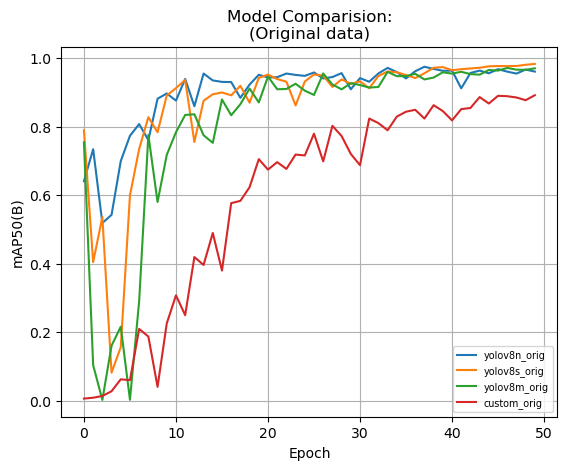

In [62]:
df_yolov8n_orig = pd.read_csv(f'{ROOT_DIR}/yolov8n_orig/results.csv')
df_yolov8n_orig.columns = df_yolov8n_orig.columns.str.strip()
mAP50_yolov8n_orig = df_yolov8n_orig['metrics/mAP50(B)']

df_yolov8s_orig = pd.read_csv(f'{ROOT_DIR}/yolov8s_orig/results.csv')
df_yolov8s_orig.columns = df_yolov8s_orig.columns.str.strip()
mAP50_yolov8s_orig = df_yolov8s_orig['metrics/mAP50(B)']

df_yolov8m_orig = pd.read_csv(f'{ROOT_DIR}/yolov8m_orig/results.csv')
df_yolov8m_orig.columns = df_yolov8m_orig.columns.str.strip()
mAP50_yolov8m_orig = df_yolov8m_orig['metrics/mAP50(B)']

df_custom_orig = pd.read_csv(f'{ROOT_DIR}/custom_orig/results.csv')
df_custom_orig.columns = df_custom_orig.columns.str.strip()
mAP50_custom_orig = df_custom_orig['metrics/mAP50(B)']


plt.plot(range(50), mAP50_yolov8n_orig, color='#1f77b4', label='yolov8n_orig')

plt.plot(range(50), mAP50_yolov8s_orig, color='#ff7f0e', label='yolov8s_orig')

plt.plot(range(50), mAP50_yolov8m_orig, color='#2ca02c', label='yolov8m_orig')

plt.plot(range(50), mAP50_custom_orig, color='#d62728', label='custom_orig')

plt.legend(loc='lower right', fontsize='x-small')
plt.xlabel('Epoch')
plt.ylabel('mAP50(B)')
plt.title('Model Comparision:\n(Original data)')
plt.grid(True)
plt.show()

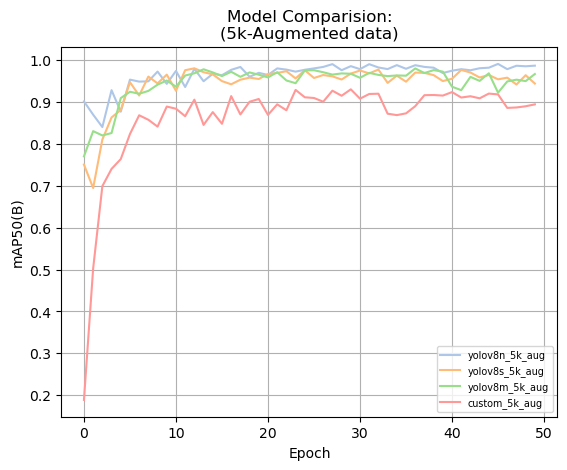

In [63]:
df_yolov8n_5k_aug = pd.read_csv(f'{ROOT_DIR}/yolov8n_5k_aug/results.csv')
df_yolov8n_5k_aug.columns = df_yolov8n_5k_aug.columns.str.strip()
mAP50_yolov8n_5k_aug = df_yolov8n_5k_aug['metrics/mAP50(B)']

df_yolov8s_5k_aug = pd.read_csv(f'{ROOT_DIR}/yolov8s_5k_aug/results.csv')
df_yolov8s_5k_aug.columns = df_yolov8s_5k_aug.columns.str.strip()
mAP50_yolov8s_5k_aug = df_yolov8s_5k_aug['metrics/mAP50(B)']

df_yolov8m_5k_aug = pd.read_csv(f'{ROOT_DIR}/yolov8m_5k_aug/results.csv')
df_yolov8m_5k_aug.columns = df_yolov8m_5k_aug.columns.str.strip()
mAP50_yolov8m_5k_aug = df_yolov8m_5k_aug['metrics/mAP50(B)']

df_custom_5k_aug = pd.read_csv(f'{ROOT_DIR}/custom_5k_aug/results.csv')
df_custom_5k_aug.columns = df_custom_5k_aug.columns.str.strip()
mAP50_custom_5k_aug = df_custom_5k_aug['metrics/mAP50(B)']

plt.plot(range(50), mAP50_yolov8n_5k_aug, color='#aec7e8', label='yolov8n_5k_aug')

plt.plot(range(50), mAP50_yolov8s_5k_aug, color='#ffbb78', label='yolov8s_5k_aug')

plt.plot(range(50), mAP50_yolov8m_5k_aug, color='#98df8a', label='yolov8m_5k_aug')

plt.plot(range(50), mAP50_custom_5k_aug, color='#ff9896', label='custom_5k_aug')

plt.legend(loc='lower right', fontsize='x-small')
plt.xlabel('Epoch')
plt.ylabel('mAP50(B)')
plt.title('Model Comparision:\n(5k-Augmented data)')
plt.grid(True)
plt.show()

### Visualisation: Ground Truth Bbox and Predict Bbox

In [71]:
def plotTrueAndPredBbox(model_valid_data, model_name):
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    # rows = 9
    # cols = 8
    # fig, ax = plt.subplots(rows, cols, figsize=(20,20))

    for i in range(4):
        # Load the image
        img_name = model_valid_data.iloc[i]['image_name']
        img = cv2.imread(f'{VAL_DIR}/valid/{img_name}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

        # Plot ground truth bbox in Green on image
        true_x1, true_y1, true_x2, true_y2 = model_valid_data.iloc[i]['true_bbox']
        cv2.rectangle(img, (true_x1, true_y1), (true_x2, true_y2), (0, 255, 0), 2)
    
        # Plot model predict bbox in Red on image
        pred_x1, pred_y1, pred_x2, pres_y2 = model_valid_data.iloc[i]['pred_bbox']
        cv2.rectangle(img, (pred_x1, pred_y1), (pred_x2, pres_y2), (255, 0, 0), 2)
    
        # Plot the image
        ax[i].imshow(img)
        ax[i].axis('off')
        # ax[i//cols, i%cols].imshow(img)
        # ax[i//cols, i%cols].axis('off')

    fig.suptitle(f'{model_name}')
    plt.tight_layout()
    plt.show()

##### Trained with Original Data

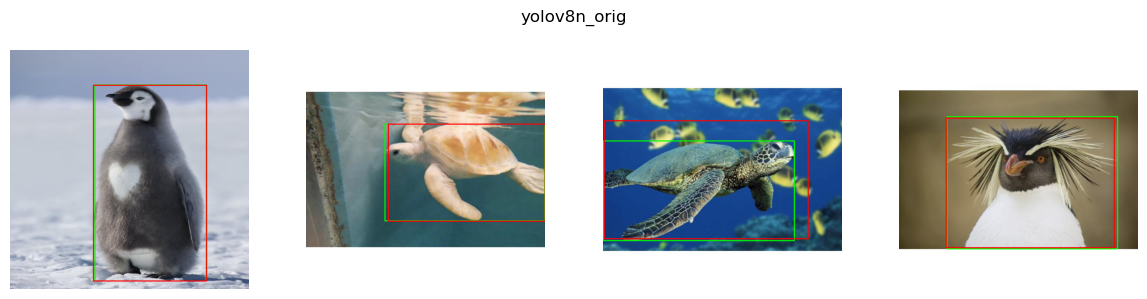

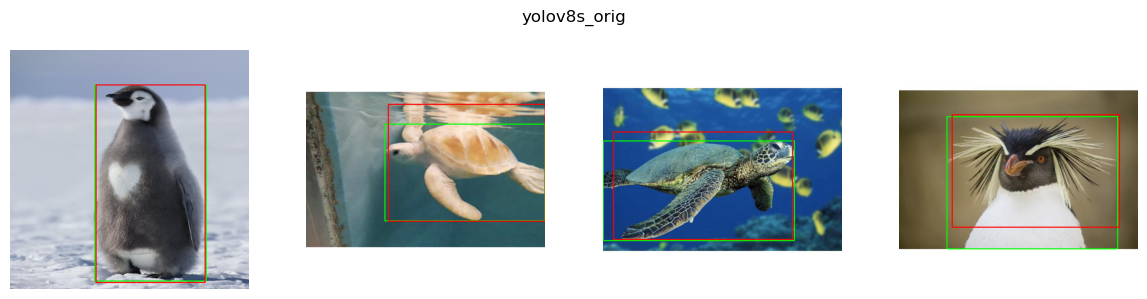

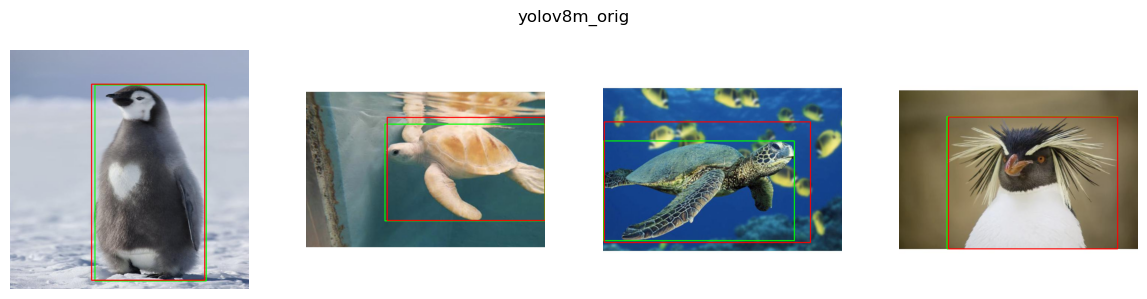

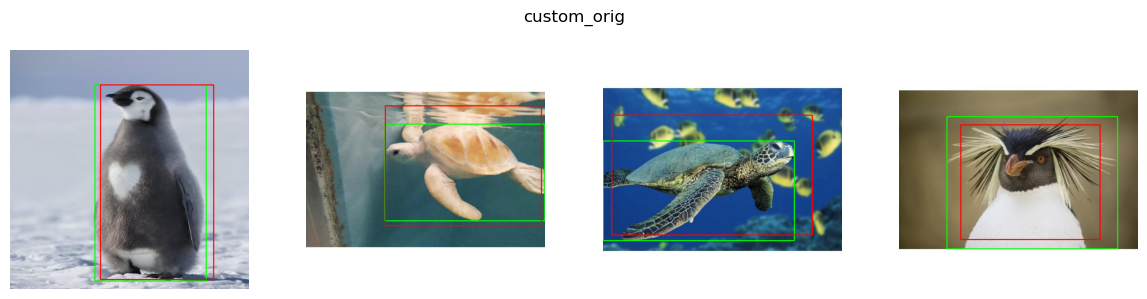

In [72]:
plotTrueAndPredBbox(val_data_yolov8n_orig, 'yolov8n_orig')
plotTrueAndPredBbox(val_data_yolov8s_orig, 'yolov8s_orig')
plotTrueAndPredBbox(val_data_yolov8m_orig, 'yolov8m_orig')
plotTrueAndPredBbox(val_data_custom_orig, 'custom_orig')

##### Trained with 5k-Augmented Data

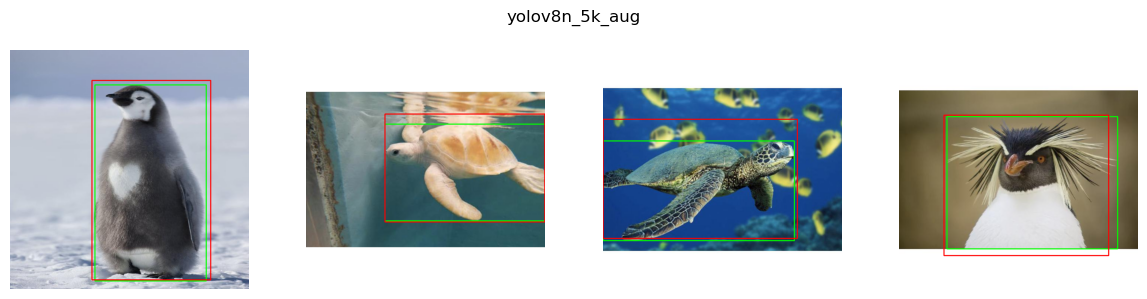

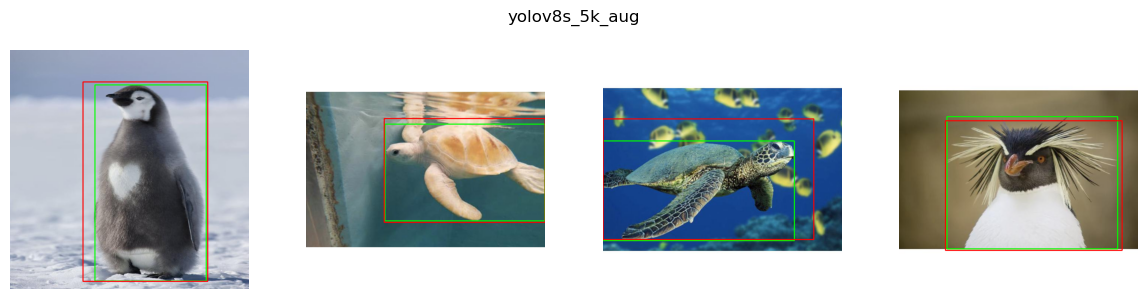

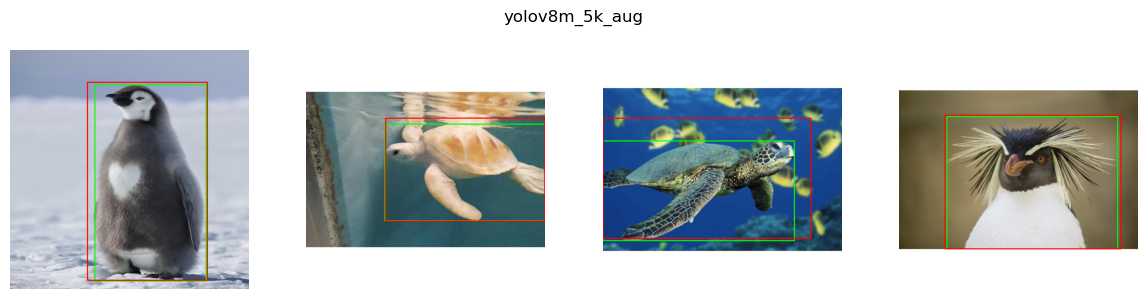

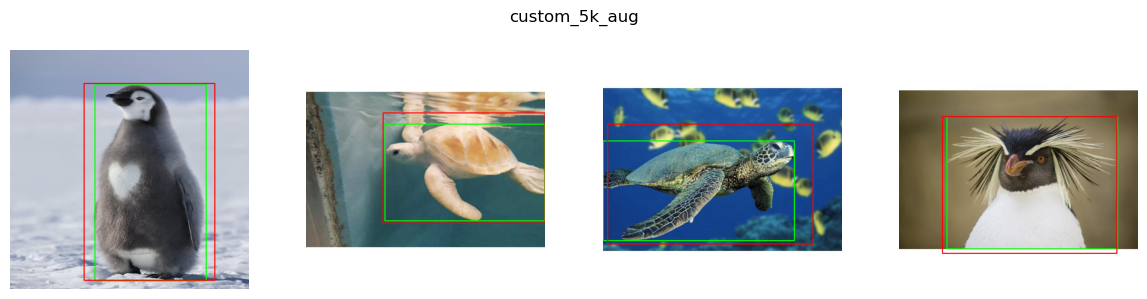

In [73]:
plotTrueAndPredBbox(val_data_yolov8n_5k_aug, 'yolov8n_5k_aug')
plotTrueAndPredBbox(val_data_yolov8s_5k_aug, 'yolov8s_5k_aug')
plotTrueAndPredBbox(val_data_yolov8m_5k_aug, 'yolov8m_5k_aug')
plotTrueAndPredBbox(val_data_custom_5k_aug, 'custom_5k_aug')